In [1]:
from __future__ import annotations

from dataclasses import dataclass, field
from typing import List, Any, Iterable, Generic, Dict, TypeVar, Hashable, Tuple, Callable
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import graphlib
import statistics

from matplotlib import pyplot as plt
import timeit
import igraph
import functools

import graphlib2
import retworkx

In [2]:
import platform

print(platform.platform())
print(platform.python_version())

macOS-12.6-arm64-arm-64bit
3.10.3


In [3]:
T = TypeVar("T", bound=Hashable)

Graph = Dict[T, List[T]]


class TopologicalSorter(Generic[T]):
    
    def prepare(self) -> None:
        ...

    def is_active(self) -> bool:
        ...
    
    def get_ready(self) -> Iterable[T]:
        ...
    
    def done(self, *nodes: T) -> None:
        ...

class RetworkXTopologicalSorter(TopologicalSorter[T]):
    def __init__(self, graph: Graph[T]) -> None:
        edge_list: "List[Tuple[T, T]]" = []
        for node, children in graph.items():
            for child in children:
                edge_list.append((node, child))
        rgraph = retworkx.PyDiGraph()
        rgraph.extend_from_edge_list(edge_list)
        self.ts = retworkx.TopologicalSorter(rgraph)

    def is_active(self) -> bool:
        return self.ts.is_active()
    
    def get_ready(self) -> Iterable[T]:
        return self.ts.get_ready()
    
    def done(self, *nodes: T) -> None:
        self.ts.done(list(nodes))
    
    def prepare(self) -> None:
        self.ts.prepare()


class GraphlibTopologicalSorter(TopologicalSorter[T]):
    def __init__(self, graph: Graph[T]) -> None:
        self.ts = graphlib.TopologicalSorter(graph)

    def is_active(self) -> bool:
        return self.ts.is_active()
    
    def get_ready(self) -> Iterable[T]:
        return self.ts.get_ready()
    
    def done(self, *nodes: T) -> None:
        self.ts.done(*nodes)
    
    def prepare(self) -> None:
        self.ts.prepare()



class Graphlib2TopologicalSorter(TopologicalSorter[T]):
    def __init__(self, graph: Graph[T]) -> None:
        self.ts = graphlib2.TopologicalSorter(graph)

    def is_active(self) -> bool:
        return self.ts.is_active()
    
    def get_ready(self) -> Iterable[T]:
        return self.ts.get_ready()
    
    def done(self, *nodes: T) -> None:
        self.ts.done(*nodes)
    
    def prepare(self) -> None:
        self.ts.prepare()


In [4]:
@functools.cache
def get_linear_graph(n: int) -> Graph[int]:
    g = igraph.Graph.Tree(n, 1)
    res: Dict[int, List[int]] = defaultdict(list)
    for source, dest in g.get_edgelist():
        res[source].append(dest)
    return res


@functools.cache
def get_branched_graph(n: int) -> Graph[int]:
    g = igraph.Graph.Tree_Game(n, directed=True)
    res: Dict[int, List[int]] = defaultdict(list)
    for source, dest in g.get_edgelist():
        res[source].append(dest)
    return res

In [5]:
Task = Callable[[TopologicalSorter[T], Graph[T]], None]

def run(
    t: TopologicalSorter[Any],
    graph: Graph[T],
) -> None:
    while t.is_active():
        t.done(*t.get_ready())


def run_threads(
    t: TopologicalSorter[Any],
    graph: Graph[T],
) -> None:
    n_threads = 8
    with ThreadPoolExecutor(n_threads) as exec:
        futures = [
            exec.submit(run, t, graph)
            for _ in range(n_threads)
        ]
        for fut in as_completed(futures):
            fut.result()

def setup_retworkx(graph: Graph[T]) -> TopologicalSorter[T]:
    return RetworkXTopologicalSorter(graph)


def setup_graphlib(graph: Graph[T]) -> TopologicalSorter[T]:
    t = GraphlibTopologicalSorter(graph)
    t.prepare()
    return t


def setup_graphlib2(graph: Graph[T]) -> TopologicalSorter[T]:
    t = Graphlib2TopologicalSorter(graph)
    t.prepare()
    return t


def copy_retworkx(ts: RetworkXTopologicalSorter[T], graph: Graph[T]) -> None:
    RetworkXTopologicalSorter(graph)


def copy_graphlib2(ts: Graphlib2TopologicalSorter[T], graph: Graph[T]) -> None:
    ts.ts.copy()


def copy_graphlib(ts: graphlib.TopologicalSorter[T], graph: Graph[T]) -> None:
    setup_graphlib(graph)

    
@dataclass
class Target:
    retworkx: Task
    graphlib: Task
    graphlib2: Task

run_tasks = Target(run, run, run)
run_thread_tasks = Target(run_threads, run_threads, run_threads)
copy_tasks = Target(copy_retworkx, copy_graphlib, copy_graphlib2)


## Time individual methods

These benchmarks are not a real Apples to Apples comparison since the methods do different amounts of work internally (even if it adds up the same total amount).

In [6]:
@dataclass
class MethodTimings:
    is_active: List[float] = field(default_factory=list)
    done: List[float] = field(default_factory=list)
    get_ready: List[float] = field(default_factory=list)


def bench_methods(ts: TopologicalSorter[T]) -> MethodTimings:
    timings = MethodTimings()
    while True:
        start = timeit.default_timer()
        is_active = ts.is_active()
        timings.is_active.append(timeit.default_timer()-start)
        if not is_active:
            break
        start = timeit.default_timer()
        ready = ts.get_ready()
        timings.get_ready.append(timeit.default_timer()-start)
        start = timeit.default_timer()
        ts.done(*ready)
        timings.done.append(timeit.default_timer()-start)
    return timings

In [7]:
def plot_method_timings(
    upper: int,
    samples: int,
    graph_factory: Callable[[int], Graph[T]],
    lower: int = 0,
    loops: int = 10,
) -> None:
    samples = min(samples, upper-lower)
    x = [round(lower + x*(upper-lower)/samples) for x in range(samples)]
    graphlib_is_active: List[float] = []
    graphlib_get_ready: List[float] = []
    graphlib_done: List[float] = []
    graphlib2_is_active: List[float] = []
    graphlib2_get_ready: List[float] = []
    graphlib2_done: List[float] = []
    retworkx_is_active: List[float] = []
    retworkx_get_ready: List[float] = []
    retworkx_done: List[float] = []
    for n in x:
        graphlib: List[MethodTimings] = []
        graphlib2: List[MethodTimings] = []
        retworkx: List[MethodTimings] = []
        graph = graph_factory(n)
        for _ in range(loops):
            graphlib.append(bench_methods(setup_graphlib(graph)))
            graphlib2.append(bench_methods(setup_graphlib2(graph)))
            retworkx.append(bench_methods(setup_retworkx(graph)))
        graphlib_is_active.append(float(statistics.median([sum(t.is_active) for t in graphlib])))
        graphlib_get_ready.append(float(statistics.median([sum(t.get_ready) for t in graphlib])))
        graphlib_done.append(float(statistics.median([sum(t.done) for t in graphlib])))
        graphlib2_is_active.append(float(statistics.median([sum(t.is_active) for t in graphlib2])))
        graphlib2_get_ready.append(float(statistics.median([sum(t.get_ready) for t in graphlib2])))
        graphlib2_done.append(float(statistics.median([sum(t.done) for t in graphlib2])))
        retworkx_is_active.append(float(statistics.median([sum(t.is_active) for t in retworkx])))
        retworkx_get_ready.append(float(statistics.median([sum(t.get_ready) for t in retworkx])))
        retworkx_done.append(float(statistics.median([sum(t.done) for t in retworkx])))
    fig, (is_active_ax, get_ready_ax, done_ax) = plt.subplots(1, 3)
    fig.text(0.5, 0.04, "V (number of vertices)", ha='center')
    fig.text(0.04, 0.5, "is_active()", va='center', rotation='vertical')
    is_active_ax.set_yticklabels([])
    is_active_ax.set_xticklabels([])
    is_active_ax.plot(x, graphlib_is_active, label="graphlib")
    is_active_ax.plot(x, graphlib2_is_active, label="graphlib2")
    is_active_ax.plot(x, retworkx_is_active, label="retworkx")
    is_active_ax.legend()
    is_active_ax.title.set_text('is_active()')
    get_ready_ax.set_yticklabels([])
    get_ready_ax.set_xticklabels([])
    get_ready_ax.plot(x, graphlib_get_ready, label="graphlib")
    get_ready_ax.plot(x, graphlib2_get_ready, label="graphlib2")
    get_ready_ax.plot(x, retworkx_get_ready, label="retworkx")
    get_ready_ax.legend()
    get_ready_ax.title.set_text('get_ready()')
    done_ax.set_yticklabels([])
    done_ax.set_xticklabels([])
    done_ax.plot(x, graphlib_done, label="graphlib")
    done_ax.plot(x, graphlib2_done, label="graphlib2")
    done_ax.plot(x, retworkx_done, label="retworkx")
    done_ax.legend()
    done_ax.title.set_text('done()')


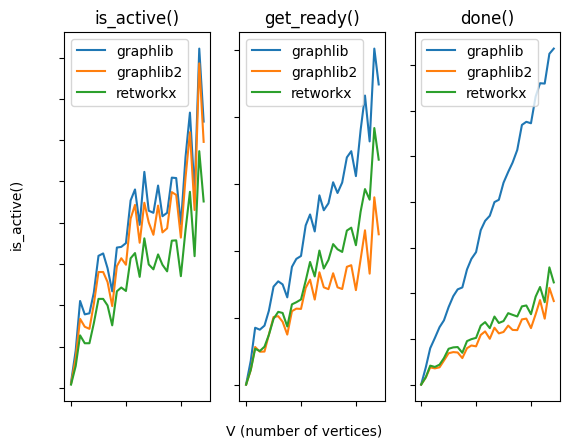

In [8]:
plot_method_timings(upper=500, samples=30, loops=20, graph_factory=get_branched_graph)

## Execution time benchmarks

Benchmarks that test how long it takes to execute the graph assuming dependencies execute instantly.
This does not count the time required to create the graph or prepare the toplogical sorter.

In [9]:
       
def plot(
    upper: int,
    samples: int,
    graph_factory: Callable[[int], Graph[T]],
    target: Target,
    lower: int = 0,
    loops: int = 10,
) -> None:
    samples = min(samples, upper - lower)
    x = [round(lower + x * (upper - lower) / samples) for x in range(samples)]
    y_graphlib: List[float] = []
    y_graphlib2: List[float] = []
    y_retworkx: List[float] = []
    for n in x:
        graphlib: List[float] = []
        graphlib2: List[float] = []
        retworkx: List[float] = []
        graph = graph_factory(n)
        for _ in range(loops):
            # graphlib
            ts = setup_graphlib(graph)
            start = timeit.default_timer()
            target.graphlib(ts, graph)
            graphlib.append(timeit.default_timer() - start)
            # graphlib2
            ts = setup_graphlib2(graph)
            start = timeit.default_timer()
            target.graphlib2(ts, graph)
            graphlib2.append(timeit.default_timer() - start)
            # retworkx
            ts = setup_retworkx(graph)
            start = timeit.default_timer()
            target.retworkx(ts, graph)
            retworkx.append(timeit.default_timer() - start)
        y_graphlib.append(statistics.median(graphlib))
        y_graphlib2.append(statistics.median(graphlib2))
        y_retworkx.append(statistics.median(retworkx))
    plt.plot(x, y_graphlib, label="graphlib")
    plt.plot(x, y_graphlib2, label="graphlib2")
    plt.plot(x, y_retworkx, label="retworkx")
    plt.legend(loc="upper left")
    plt.xlabel("V (number of vertices)")
    plt.ylabel("Execution time (s)")


For a linear graph (`{"A": ["B"], "B": ["C"], "C": ["D"]}`):

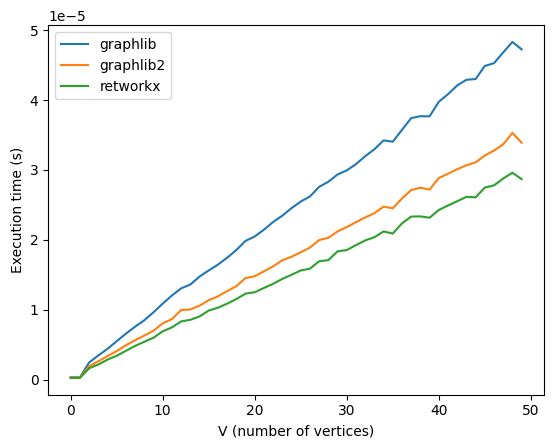

In [10]:
plot(upper=50, samples=50, loops=30, graph_factory=get_linear_graph, target=run_tasks)

For a randomized branched graph (`{"A": ["B", "C"], "B": ["C"], "C": ["D", "E"]}`):

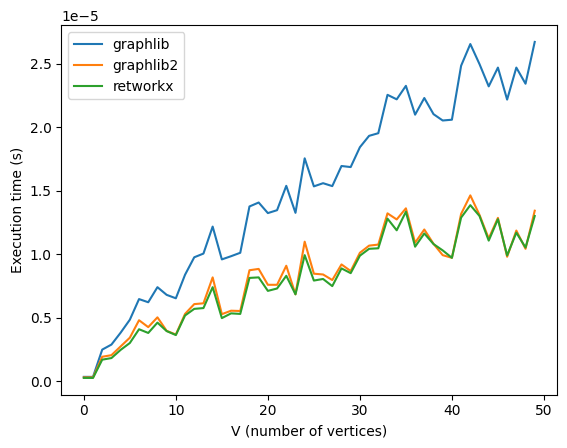

In [11]:
plot(upper=50, samples=50, loops=30, graph_factory=get_branched_graph, target=run_tasks)

Same benchmarks for much larger graphs

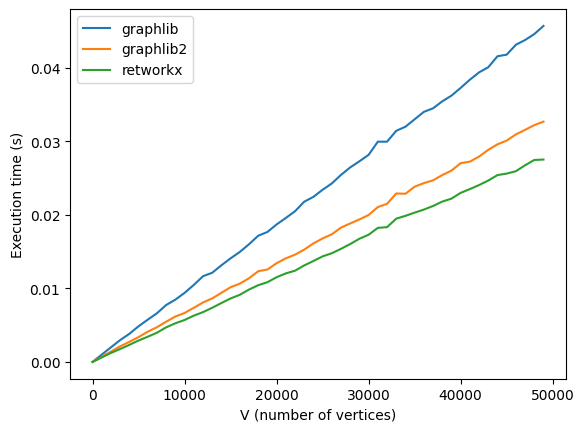

In [12]:
plot(upper=50_000, samples=50, loops=7, graph_factory=get_linear_graph, target=run_tasks)

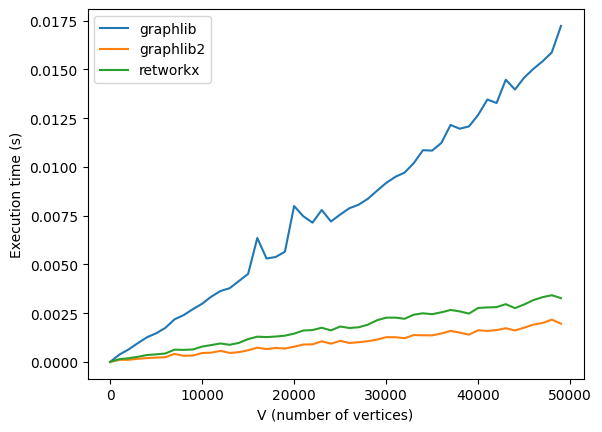

In [13]:
plot(upper=50_000, samples=50, loops=7, graph_factory=get_branched_graph, target=run_tasks)

### Execution of a medium sized branched graph in threads

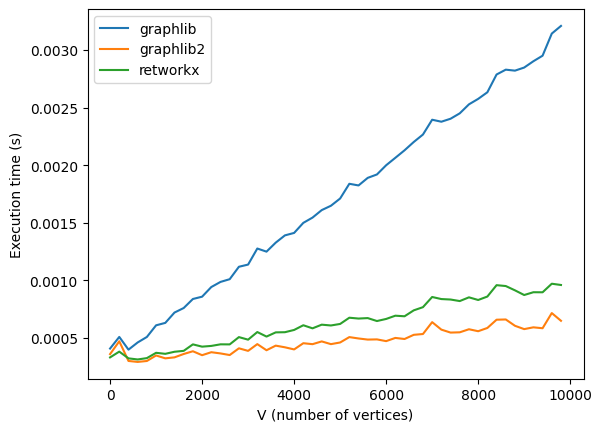

In [14]:
plot(upper=10_000, samples=50, loops=7, graph_factory=get_branched_graph, target=run_thread_tasks)

## Copy benchmarks

Measure copying a `ToplogicalSorter` instance.
The standard library does not have a `copy()` method, so we just re-create the `ToplogicalSorter`, which is inefficient but is the only option available.

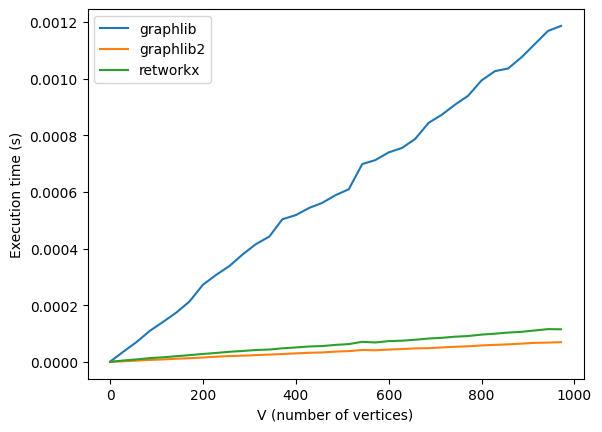

In [15]:
plot(upper=1_000, samples=35, loops=15, graph_factory=get_branched_graph, target=copy_tasks)

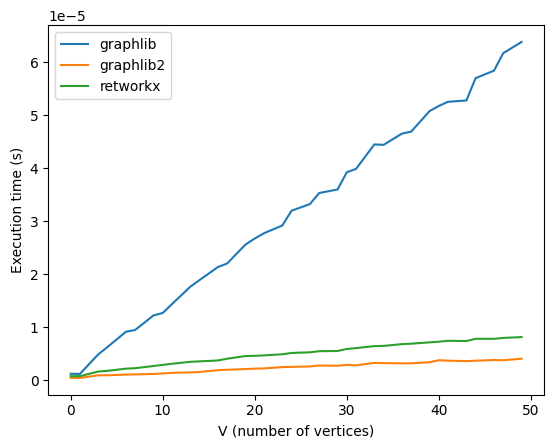

In [16]:
plot(upper=50, samples=35, loops=15, graph_factory=get_branched_graph, target=copy_tasks)

Time copying a `graphlib2.ToplogicalSorter` so it can be compared against itself

In [17]:
%%timeit copy_ts = setup_graphlib2(get_branched_graph(10_000)).ts.copy
copy_ts()

685 µs ± 5.48 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
